# Proactive Customer Retention: Detecting Relocation & Attrition Risk via Transaction Analysis

**Objective**: <br>
To develop a data-driven model that proactively identifies Chase Community Bank customers who are likely to have relocated. The goal is to flag these customers as being at high risk of attrition, creating an opportunity for targeted retention campaigns. <br>
<br>
**Methodology**: <br>
A weighted scoring model was developed based on 12 months of synthetic customer transaction data. The model assigns higher weights to recurring, location-dependent purchases (e.g., groceries, utilities) to distinguish true relocation signals from incidental travel. A customer is flagged as a "likely mover" if their weighted spending outside their home zip code remains high for three or more consecutive months. <br>

<br>

**Key Findings**: <br>
*   High-Value Customers are the Most Mobile: The analysis of the 227 customers flagged by the model revealed that the 'Affluent' segment represents the largest group of movers. This indicates that the bank's most valuable customers may also be the most likely to relocate and, therefore, are at the highest risk of churn.
*   Relocation is Not Just a Young Person's Game: Customers in the 36-50 and 50+ age brackets were the most common groups identified by the model, suggesting that retention efforts should not be limited to younger demographics.

<br>

**Model Performance**: <br>
The model was designed as a "safety net" to maximize the identification of at-risk customers. <br>

*   Recall: 100.00% - The model successfully identified every single true mover in the dataset, ensuring no retention opportunity is missed.
*   Precision: 37.00% - The model also flags customers with non-traditional "super commuter" lifestyles, providing valuable secondary insights into the customer base.

<br>

**Recommendation**:<br>
Based on the finding that affluent customers are the highest-risk group, we recommend developing a pilot program for a proactive outreach campaign. This campaign should be automatically triggered when an 'Affluent' segment customer's relocation score crosses a high threshold. The outreach could offer personalized assistance with moving-related banking needs (e.g., updating addresses, information on local branches, mortgage pre-approval offers) to reinforce the banking relationship during a critical life event and increase retention of this high-value segment.



## **Phase 1: Data Preparation**

### Loading

In [3]:
import pandas as pd

# Define the file paths
customers_path = 'data/customers.csv'
branches_path = 'data/branches.csv'
zip_demographics_path = 'data/zip_demographics.csv'
accounts_path = 'data/accounts.csv'
merchants_path = 'data/merchants.csv'
transactions_path = 'data/transactions.csv'
deposits_payroll_path = 'data/deposits_payroll.csv'
atms_path = 'data/atms.csv'

# Task 1.1: Load each CSV into a pandas DataFrame
customers_df = pd.read_csv(customers_path)
branches_df = pd.read_csv(branches_path)
zip_demographics_df = pd.read_csv(zip_demographics_path)
accounts_df = pd.read_csv(accounts_path)
merchants_df = pd.read_csv(merchants_path)
transactions_df = pd.read_csv(transactions_path)
deposits_payroll_df = pd.read_csv(deposits_payroll_path)
atms_df = pd.read_csv(atms_path)

# --- Verification Step ---
print("✅ Task 1.1 Complete: All 8 CSV files have been loaded into DataFrames for analysis.")
print(f"The transactions_df DataFrame has {len(transactions_df)} rows.")

✅ Task 1.1 Complete: All 8 CSV files have been loaded into DataFrames for analysis.
The transactions_df DataFrame has 270667 rows.


### Cleaning

In [4]:
# Convert date columns in the transactions table
transactions_df['post_date'] = pd.to_datetime(transactions_df['post_date'])

# Convert date columns in the deposits table
deposits_payroll_df['post_date'] = pd.to_datetime(deposits_payroll_df['post_date'])

# Convert date columns in the customers table
customers_df['relationship_start_date'] = pd.to_datetime(customers_df['relationship_start_date'])

# Convert date columns in the accounts table
accounts_df['open_date'] = pd.to_datetime(accounts_df['open_date'])

print("✅ Date columns successfully converted.")

✅ Date columns successfully converted.


In [5]:
# Check the data types for the transactions table again
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270667 entries, 0 to 270666
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   txn_id             270667 non-null  object        
 1   account_id         270667 non-null  object        
 2   customer_id        270667 non-null  object        
 3   merchant_id        270667 non-null  object        
 4   post_date          270667 non-null  datetime64[ns]
 5   amount             270667 non-null  float64       
 6   channel            270667 non-null  object        
 7   payment_rail       270667 non-null  object        
 8   txn_zip            270667 non-null  int64         
 9   mcc_group          270667 non-null  object        
 10  is_recurring_like  270667 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 20.9+ MB


In [6]:
# Check for missing values in the transactions dataframe
print("Missing values per column in transactions_df:")
transactions_df.isnull().sum()

Missing values per column in transactions_df:


,0
txn_id,0
account_id,0
customer_id,0
merchant_id,0
post_date,0
amount,0
channel,0
payment_rail,0
txn_zip,0
mcc_group,0


### Merging & Cleanup

In [7]:
# --- Merging DataFrames ---

# I started with the main transactions table and add customer information
# Then, I join on 'customer_id', which exists in both tables.
master_df = pd.merge(transactions_df, customers_df, on='customer_id', how='left')

# Now, add merchant information to our new master_df
# Join on 'merchant_id'
master_df = pd.merge(master_df, merchants_df, on='merchant_id', how='left')

# Last, let's add the account information (like product_type)
# Join on 'account_id'
master_df = pd.merge(master_df, accounts_df, on='account_id', how='left')


# --- Verification Step ---
print("✅ Merge complete. All data is now in a single master_df DataFrame.")
print("The master DataFrame has a new shape:", master_df.shape)

print("\n--- Master DataFrame Preview ---")
# Display the first few rows. Notice the new columns
display(master_df.head())

✅ Merge complete. All data is now in a single master_df DataFrame.
The master DataFrame has a new shape: (270667, 27)

--- Master DataFrame Preview ---


,txn_id,account_id,customer_id_x,merchant_id,post_date,amount,channel,payment_rail,txn_zip,mcc_group_x,...,household_flag,has_moved,merchant_name,mcc_group_y,zip,brand,customer_id_y,product_type,is_primary_dd,open_date
0,T1000000,A50000,C10001,M8043,2024-10-04 06:24:20.645344,353.73,Online,Debit,90097,Retail,...,False,False,Retail Chain 2,Retail,90097,RetailCo,C10001,Checking,True,2023-04-06
1,T1000001,A50000,C10001,M8043,2024-10-04 06:24:20.645344,405.55,Mobile,Debit,90097,Retail,...,False,False,Retail Chain 2,Retail,90097,RetailCo,C10001,Checking,True,2023-04-06
2,T1000002,A50000,C10001,M8034,2024-10-04 06:24:20.645344,79.78,POS,Debit,90097,Gas,...,False,False,Gas Chain 2,Gas,90097,GasCo,C10001,Checking,True,2023-04-06
3,T1000003,A50000,C10001,M8033,2024-10-05 06:24:20.645344,64.74,Online,Debit,90039,Gas,...,False,False,Gas Chain 1,Gas,90039,GasCo,C10001,Checking,True,2023-04-06
4,T1000004,A50000,C10001,M8042,2024-10-05 06:24:20.645344,104.16,Online,Debit,90039,Retail,...,False,False,Retail Chain 1,Retail,90039,RetailCo,C10001,Checking,True,2023-04-06


In [8]:
# --- Clean Up After Merging ---

# 1. Identify the redundant columns I want to remove (the '_y' versions)
#    We will also drop the duplicate customer_id from the accounts table.
#    Note: spotted a few others from the merge that I can clean up.
cols_to_drop = ['customer_id_y', 'mcc_group_y', 'zip']
master_df = master_df.drop(columns=cols_to_drop)


# 2. Rename the '_x' columns back to their original clean names
cols_to_rename = {
    'customer_id_x': 'customer_id',
    'mcc_group_x': 'mcc_group'
}
master_df = master_df.rename(columns=cols_to_rename)


# --- Verification Step ---
print("✅ Merge artifacts cleaned up successfully.")
print("The master DataFrame now has a final shape of:", master_df.shape)

print("\n--- Final Cleaned Master DataFrame Preview ---")
# Display the head again to see the clean column names
display(master_df.head())

print("\n--- Final Column List ---")
# Display the final list of columns
print(master_df.columns.tolist())

✅ Merge artifacts cleaned up successfully.
The master DataFrame now has a final shape of: (270667, 24)

--- Final Cleaned Master DataFrame Preview ---


,txn_id,account_id,customer_id,merchant_id,post_date,amount,channel,payment_rail,txn_zip,mcc_group,...,relationship_start_date,primary_branch_id,state_start,household_flag,has_moved,merchant_name,brand,product_type,is_primary_dd,open_date
0,T1000000,A50000,C10001,M8043,2024-10-04 06:24:20.645344,353.73,Online,Debit,90097,Retail,...,2023-03-24,B121,CA,False,False,Retail Chain 2,RetailCo,Checking,True,2023-04-06
1,T1000001,A50000,C10001,M8043,2024-10-04 06:24:20.645344,405.55,Mobile,Debit,90097,Retail,...,2023-03-24,B121,CA,False,False,Retail Chain 2,RetailCo,Checking,True,2023-04-06
2,T1000002,A50000,C10001,M8034,2024-10-04 06:24:20.645344,79.78,POS,Debit,90097,Gas,...,2023-03-24,B121,CA,False,False,Gas Chain 2,GasCo,Checking,True,2023-04-06
3,T1000003,A50000,C10001,M8033,2024-10-05 06:24:20.645344,64.74,Online,Debit,90039,Gas,...,2023-03-24,B121,CA,False,False,Gas Chain 1,GasCo,Checking,True,2023-04-06
4,T1000004,A50000,C10001,M8042,2024-10-05 06:24:20.645344,104.16,Online,Debit,90039,Retail,...,2023-03-24,B121,CA,False,False,Retail Chain 1,RetailCo,Checking,True,2023-04-06



--- Final Column List ---
['txn_id', 'account_id', 'customer_id', 'merchant_id', 'post_date', 'amount', 'channel', 'payment_rail', 'txn_zip', 'mcc_group', 'is_recurring_like', 'home_zip_start', 'dob_year_bucket', 'segment', 'relationship_start_date', 'primary_branch_id', 'state_start', 'household_flag', 'has_moved', 'merchant_name', 'brand', 'product_type', 'is_primary_dd', 'open_date']


## **Phase 2: Developing the Relocation Score (The Core Logic)**

### Monthly Aggregation

In [9]:
# --- Create Monthly Aggregations ---

# 1. Create a 'yyyymm' column to allow for monthly grouping.
#    .dt.to_period('M') is a handy pandas function for this.
master_df['yyyymm'] = master_df['post_date'].dt.to_period('M')

# 2. Group by customer, month, and location to sum up their spending.
#    We include mcc_group to know the category and home_zip_start to compare against.
monthly_agg_df = master_df.groupby([
    'customer_id',
    'yyyymm',
    'home_zip_start',
    'txn_zip',
    'mcc_group'
]).agg(
    monthly_spend=('amount', 'sum')
).reset_index()


# --- Verification Step ---
print("✅ Monthly aggregation complete.")
print(f"The new monthly_agg_df DataFrame has {len(monthly_agg_df)} rows.")

print("\n--- Monthly Aggregated DataFrame Preview ---")
display(monthly_agg_df.head(10))

✅ Monthly aggregation complete.
The new monthly_agg_df DataFrame has 48138 rows.

--- Monthly Aggregated DataFrame Preview ---


,customer_id,yyyymm,home_zip_start,txn_zip,mcc_group,monthly_spend
0,C10001,2024-10,90056,33147,Retail,347.55
1,C10001,2024-10,90056,60624,Restaurants,92.83
2,C10001,2024-10,90056,90017,Restaurants,369.23
3,C10001,2024-10,90056,90017,Retail,1285.62
4,C10001,2024-10,90056,90039,Gas,827.20
5,C10001,2024-10,90056,90039,Pharmacy,577.40
6,C10001,2024-10,90056,90039,Retail,2793.26
7,C10001,2024-10,90056,90041,Grocery,628.31
8,C10001,2024-10,90056,90056,Pharmacy,502.06
9,C10001,2024-10,90056,90056,Restaurants,315.57


### Score Calculation

**Develop the Weighted Relocation Score** <br>

<br>

The "Why": <br>

Our goal is to create a single number for each customer, each month, that signals how likely it is they've moved. A high score will mean their important spending is happening away from their home, while a low score means their activity is normal.<br>

<br>

We will do this by:<br>

Applying weights to different spending categories.<br>

Calculating the percentage of weighted spending happening "away" from home each month.<br>

Smoothing this score over a 3-month window to ignore noise from things like vacations.<br>

<br>

The "How":<br>
This will be a multi-step process. The code below will perform all the necessary calculations to create our final score.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Develop the Weighted Relocation Score ---

# 1. Define our category weights in a dictionary
category_weights = {
    'Grocery': 0.35,
    'Utilities': 0.25,
    'Gas': 0.15,
    'Pharmacy': 0.15,
    'Restaurants': 0.05,
    'Retail': 0.05,
    'Travel': 0.00
}

# 2. Apply these weights to our monthly spending data
# .map() is a great way to do this. We fill any non-matching categories with a weight of 0.
monthly_agg_df['category_weight'] = monthly_agg_df['mcc_group'].map(category_weights).fillna(0)
monthly_agg_df['weighted_spend'] = monthly_agg_df['monthly_spend'] * monthly_agg_df['category_weight']

# 3. Calculate the monthly relocation score for each customer
# First, find the total weighted spend per customer per month
customer_monthly_totals = monthly_agg_df.groupby(['customer_id', 'yyyymm'])['weighted_spend'].sum().reset_index()
customer_monthly_totals = customer_monthly_totals.rename(columns={'weighted_spend': 'total_monthly_weighted_spend'})

# Next, find the total weighted spend that happened AWAY from home
away_spend = monthly_agg_df[monthly_agg_df['txn_zip'] != monthly_agg_df['home_zip_start']]
customer_away_spend = away_spend.groupby(['customer_id', 'yyyymm'])['weighted_spend'].sum().reset_index()
customer_away_spend = customer_away_spend.rename(columns={'weighted_spend': 'away_monthly_weighted_spend'})

# Merge these calculations together
relocation_scores_df = pd.merge(customer_monthly_totals, customer_away_spend, on=['customer_id', 'yyyymm'], how='left')
# If a customer had no away spend in a month, the value will be NaN. We fill it with 0.
relocation_scores_df['away_monthly_weighted_spend'] = relocation_scores_df['away_monthly_weighted_spend'].fillna(0)

# Calculate the final monthly score
relocation_scores_df['monthly_score'] = relocation_scores_df['away_monthly_weighted_spend'] / relocation_scores_df['total_monthly_weighted_spend']
# Handle cases where total weighted spend is 0 to avoid division by zero errors
relocation_scores_df['monthly_score'] = relocation_scores_df['monthly_score'].fillna(0)


# 4. Smooth the score with a 3-month rolling average
# This is crucial to filter out noise from short trips or vacations.
# We sort by customer and date to make sure the rolling window is correct.
relocation_scores_df = relocation_scores_df.sort_values(['customer_id', 'yyyymm'])
# The groupby() ensures the rolling average is calculated independently for each customer.
relocation_scores_df['relocation_score_3m'] = relocation_scores_df.groupby('customer_id')['monthly_score'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())


# --- Verification Step ---
print("✅ Relocation score calculation complete.")
print("\n--- Relocation Scores DataFrame Preview ---")
display(relocation_scores_df.head(10))

✅ Relocation score calculation complete.

--- Relocation Scores DataFrame Preview ---


,customer_id,yyyymm,total_monthly_weighted_spend,away_monthly_weighted_spend,monthly_score,relocation_score_3m
0,C10001,2024-10,1257.1415,1166.0540,0.927544,0.927544
1,C10001,2024-11,1694.2755,1626.9515,0.960264,0.943904
2,C10001,2024-12,1477.2270,1410.7165,0.954976,0.947595
3,C10001,2025-01,1444.0885,1352.0725,0.936281,0.950507
4,C10001,2025-02,1427.0130,1362.4590,0.954763,0.948673
5,C10001,2025-03,1454.8240,1322.7480,0.909215,0.933420
6,C10001,2025-04,1442.6525,1423.0670,0.986424,0.950134
7,C10001,2025-05,1253.0745,1204.8290,0.961498,0.952379
8,C10001,2025-06,1529.7320,1429.9295,0.934758,0.960893
9,C10001,2025-07,1273.3240,1185.1750,0.930773,0.942343


### Atchetype Analysis

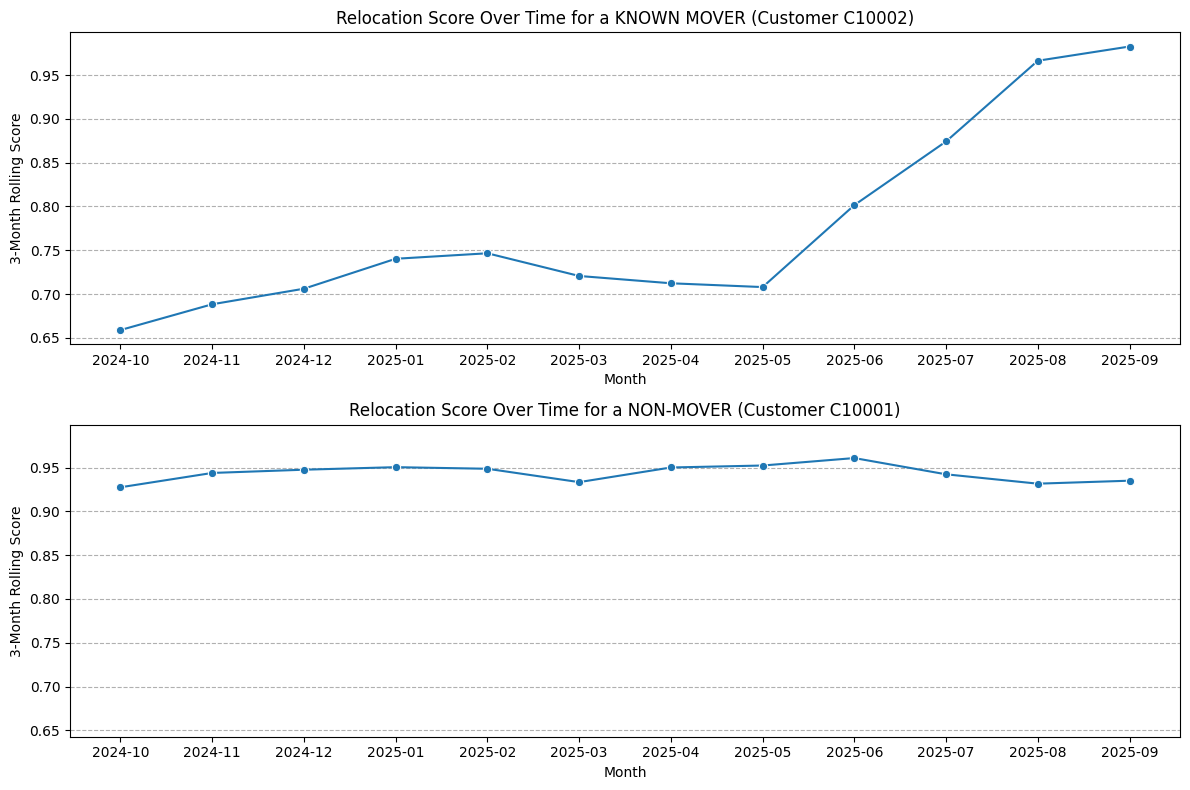

In [11]:
# --- Visualize the Score ---

# THE FIX: Convert the 'yyyymm' Period object to a string for plotting
relocation_scores_df['yyyymm'] = relocation_scores_df['yyyymm'].astype(str)

# Find one customer who moved and one who didn't from our original customers_df
mover_id = customers_df[customers_df['has_moved'] == True]['customer_id'].iloc[0]
non_mover_id = customers_df[customers_df['has_moved'] == False]['customer_id'].iloc[0]

# Get their score data
mover_scores = relocation_scores_df[relocation_scores_df['customer_id'] == mover_id]
non_mover_scores = relocation_scores_df[relocation_scores_df['customer_id'] == non_mover_id]

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharey=True)
sns.lineplot(data=mover_scores, x='yyyymm', y='relocation_score_3m', marker='o', ax=ax1)
ax1.set_title(f'Relocation Score Over Time for a KNOWN MOVER (Customer {mover_id})')
ax1.set_xlabel('Month')
ax1.set_ylabel('3-Month Rolling Score')
ax1.grid(axis='y', linestyle='--')

sns.lineplot(data=non_mover_scores, x='yyyymm', y='relocation_score_3m', marker='o', ax=ax2)
ax2.set_title(f'Relocation Score Over Time for a NON-MOVER (Customer {non_mover_id})')
ax2.set_xlabel('Month')
ax2.set_ylabel('3-Month Rolling Score')
ax2.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

Investigating Customer C10001

In [12]:
# Let's investigate the NON-MOVER who has a high score
investigate_id = 'C10001'

# Filter our monthly aggregated data for only this customer
customer_details = monthly_agg_df[monthly_agg_df['customer_id'] == investigate_id]

print(f"--- Spending Pattern for Customer {investigate_id} ---")
display(customer_details)

--- Spending Pattern for Customer C10001 ---


,customer_id,yyyymm,home_zip_start,txn_zip,mcc_group,monthly_spend,category_weight,weighted_spend
0,C10001,2024-10,90056,33147,Retail,347.55,0.05,17.3775
1,C10001,2024-10,90056,60624,Restaurants,92.83,0.05,4.6415
2,C10001,2024-10,90056,90017,Restaurants,369.23,0.05,18.4615
3,C10001,2024-10,90056,90017,Retail,1285.62,0.05,64.2810
4,C10001,2024-10,90056,90039,Gas,827.20,0.15,124.0800
...,...,...,...,...,...,...,...,...
193,C10001,2025-09,90056,90097,Gas,410.52,0.15,61.5780
194,C10001,2025-09,90056,90097,Grocery,915.38,0.35,320.3830
195,C10001,2025-09,90056,90097,Pharmacy,64.03,0.15,9.6045
196,C10001,2025-09,90056,90097,Restaurants,425.35,0.05,21.2675


Finding a True Non-Mover

In [13]:
# Get the list of all customers we know are non-movers
all_non_mover_ids = customers_df[customers_df['has_moved'] == False]['customer_id'].tolist()

# Filter our scores table to only include these non-movers
non_mover_scores_all = relocation_scores_df[relocation_scores_df['customer_id'].isin(all_non_mover_ids)]

# For each of these non-movers, find their average score for the year
avg_scores = non_mover_scores_all.groupby('customer_id')['relocation_score_3m'].mean()

# Find the customer ID with the absolute lowest average score
true_non_mover_id = avg_scores.idxmin()

print(f"The original 'non-mover' (our Super Commuter) was: {non_mover_id}")
print(f"Found a 'True Non-Mover' with the lowest score: {true_non_mover_id}")

The original 'non-mover' (our Super Commuter) was: C10001
Found a 'True Non-Mover' with the lowest score: C10049


Final Chart

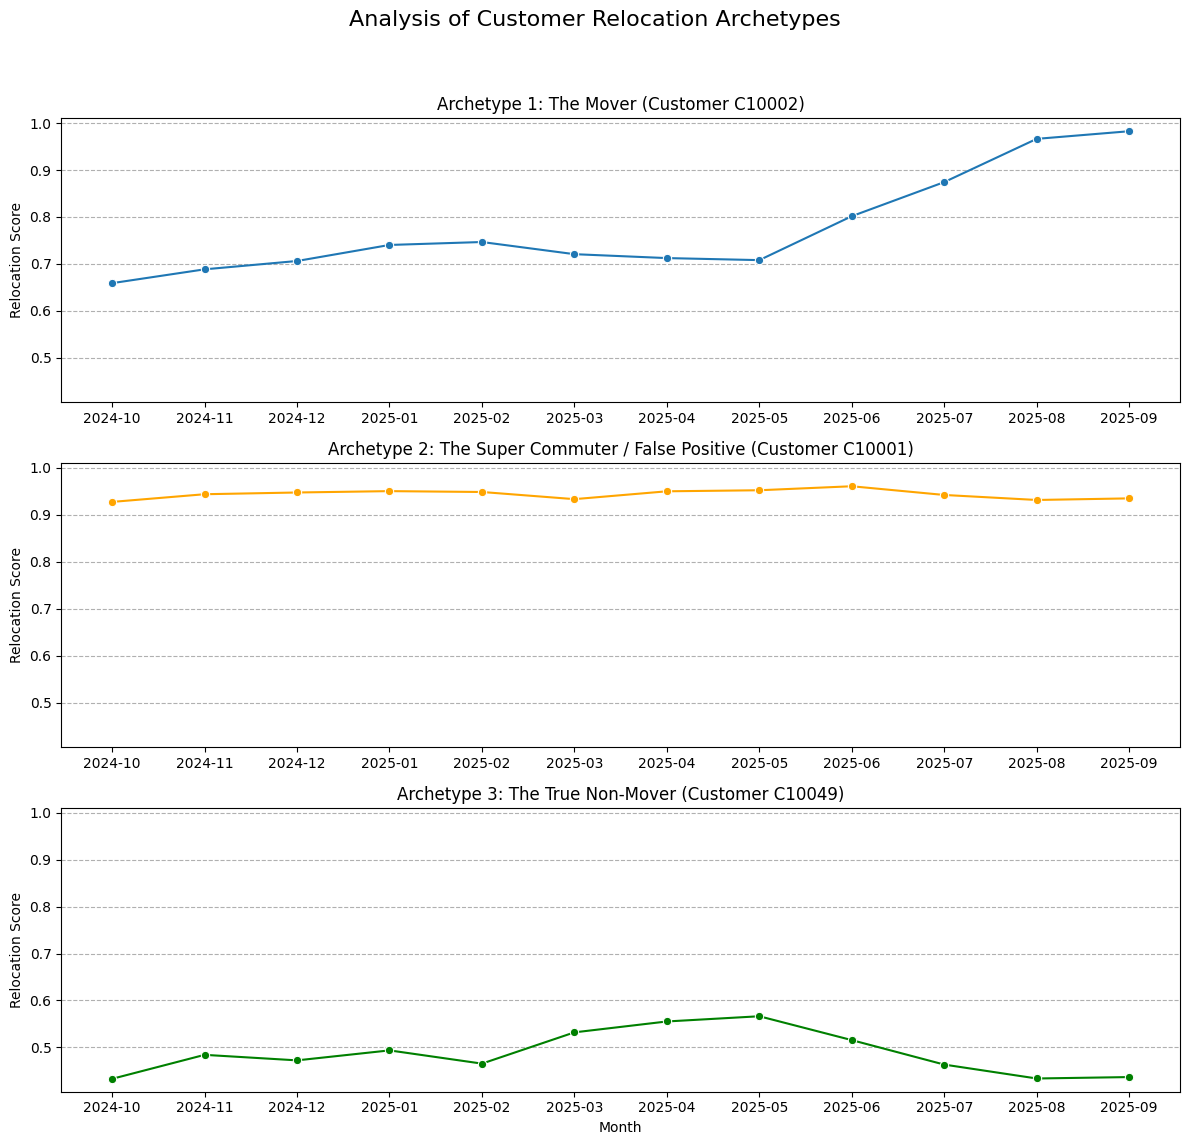

In [14]:
# --- Create New 3-Panel Comparison Chart ---

# Get the data for all three customer archetypes
mover_scores = relocation_scores_df[relocation_scores_df['customer_id'] == mover_id]
super_commuter_scores = relocation_scores_df[relocation_scores_df['customer_id'] == non_mover_id] # This is our original C10001
true_non_mover_scores = relocation_scores_df[relocation_scores_df['customer_id'] == true_non_mover_id]

# Create the plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharey=True)
fig.suptitle('Analysis of Customer Relocation Archetypes', fontsize=16)

# 1. Plot for the Known Mover
sns.lineplot(data=mover_scores, x='yyyymm', y='relocation_score_3m', marker='o', ax=ax1)
ax1.set_title(f'Archetype 1: The Mover (Customer {mover_id})')
ax1.set_xlabel('')
ax1.set_ylabel('Relocation Score')
ax1.grid(axis='y', linestyle='--')

# 2. Plot for the Super Commuter (False Positive)
sns.lineplot(data=super_commuter_scores, x='yyyymm', y='relocation_score_3m', marker='o', ax=ax2, color='orange')
ax2.set_title(f'Archetype 2: The Super Commuter / False Positive (Customer {non_mover_id})')
ax2.set_xlabel('')
ax2.set_ylabel('Relocation Score')
ax2.grid(axis='y', linestyle='--')

# 3. Plot for the True Non-Mover
sns.lineplot(data=true_non_mover_scores, x='yyyymm', y='relocation_score_3m', marker='o', ax=ax3, color='green')
ax3.set_title(f'Archetype 3: The True Non-Mover (Customer {true_non_mover_id})')
ax3.set_xlabel('Month')
ax3.set_ylabel('Relocation Score')
ax3.grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Phase 3: Model Validation & Performance**

### Business Rule Application

The code below is the same as before, but now we can run it with much more confidence in the results. It will apply our score > 0.7 for 3+ months rule to all 250 customers

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Apply the Business Rule to Flag Movers ---

# 1. First, create a helper column that is True if the score is high in a given month
relocation_scores_df['is_high_score'] = relocation_scores_df['relocation_score_3m'] > 0.7

# 2. Now, check for 3 consecutive months of high scores.
relocation_scores_df['high_score_streak'] = relocation_scores_df.groupby('customer_id')['is_high_score'].transform(lambda x: x.rolling(window=3).sum())

# 3. Get a final list of customers who had a streak of 3 at any point
likely_movers = relocation_scores_df[relocation_scores_df['high_score_streak'] >= 3]['customer_id'].unique()

# Add our prediction flag to the original customers_df
customers_df['predicted_mover'] = customers_df['customer_id'].isin(likely_movers)

### Performance Metrics

Generate the final performance metrics (Precision, Recall) and the Confusion Matrix.

Model Performance:
Precision: 37.00%
Recall: 100.00%


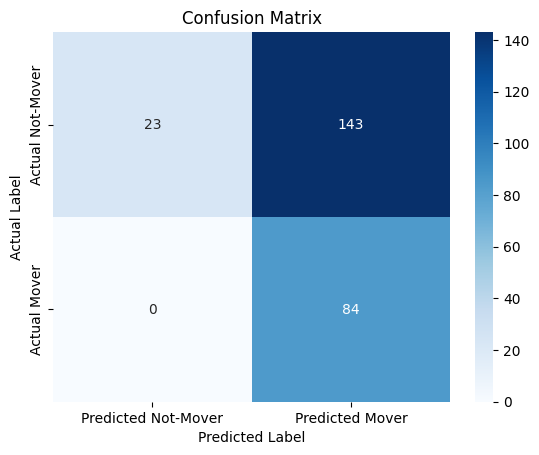

In [16]:
# --- Validate the Model's Performance ---

# 1. Get our ground truth and our predictions
true_labels = customers_df['has_moved']
predicted_labels = customers_df['predicted_mover']

# 2. Calculate Precision and Recall
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

print(f"Model Performance:")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

# 3. Create the Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not-Mover', 'Predicted Mover'], yticklabels=['Actual Not-Mover', 'Actual Mover'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## **Phase 4: Business Insights & Final Analysis**

### Mover Demographics

Our first step is to understand the characteristics of the customers we've flagged. A VP at the bank doesn't just want a list of names; they want to know what kinds of customers are at risk. <br>
<br>
The "Why": <br>
We will analyze the demographics of the group you flagged as Predicted Mover. This will tell us if a particular type of customer (e.g., "Affluent" or "Younger") is more likely to relocate, which is a key strategic insight for marketing and retention efforts. <br>
<br>
The "How": <br>
We will filter our customers_df for only the movers our model predicted, and then create visualizations to see their breakdown by segment and age.

Our model flagged 227 customers as likely movers.
Let's analyze the characteristics of this group.


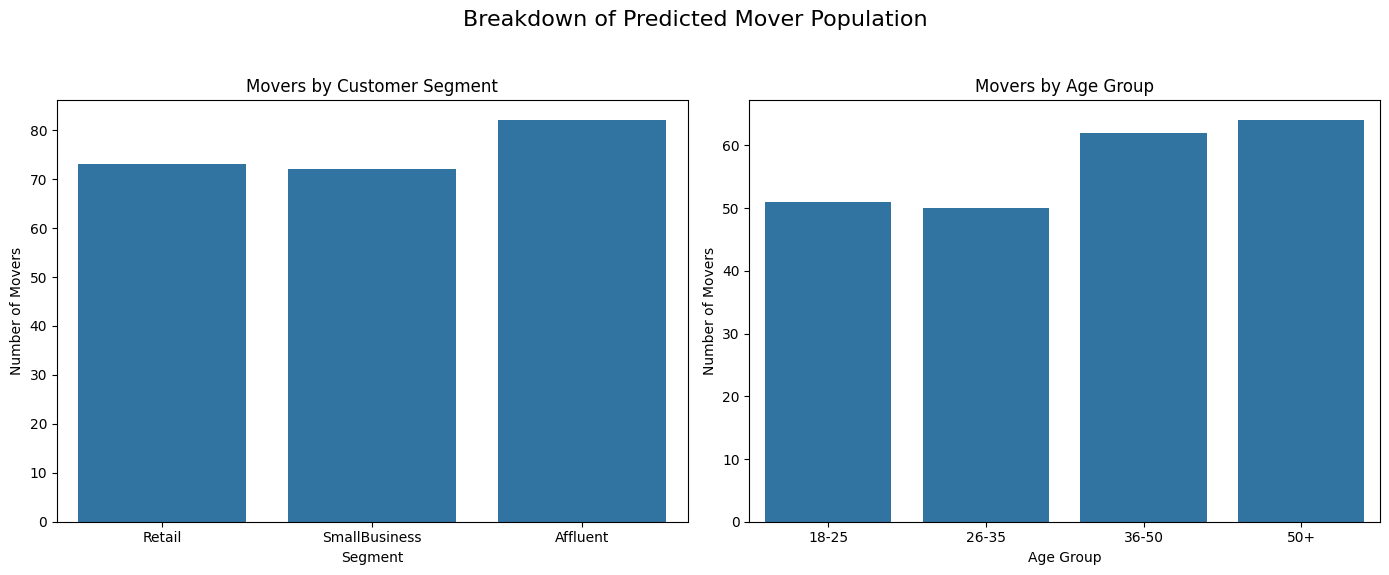

In [17]:
# --- Analyze the Mover Population ---

# 1. Create a new DataFrame containing only the customers our model flagged as movers.
predicted_movers_df = customers_df[customers_df['predicted_mover'] == True]

print(f"Our model flagged {len(predicted_movers_df)} customers as likely movers.")
print("Let's analyze the characteristics of this group.")

# 2. Create visualizations to understand their composition.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Breakdown of Predicted Mover Population', fontsize=16)

# Plot 1: Breakdown by Customer Segment
sns.countplot(data=predicted_movers_df, x='segment', ax=ax1, order=['Retail', 'SmallBusiness', 'Affluent'])
ax1.set_title('Movers by Customer Segment')
ax1.set_xlabel('Segment')
ax1.set_ylabel('Number of Movers')

# Plot 2: Breakdown by Age Group
sns.countplot(data=predicted_movers_df, x='dob_year_bucket', ax=ax2, order=['18-25', '26-35', '36-50', '50+'])
ax2.set_title('Movers by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Number of Movers')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Final Insights

Movers by Customer Segment: The chart on the left is the most critical finding. It shows that the 'Affluent' segment has the highest number of movers. This is a hugely important insight for a bank, as these are often their most valuable customers. Losing them represents a significant financial impact.<br>
<br>
Movers by Age Group: The chart on the right shows that customers in the 36-50 and 50+ age brackets are the most represented groups among the movers. This might be contrary to a common assumption that younger people are more mobile.

## **Appendix: Data Generation Script**

### Data Generation Script

In [1]:
# Install Faker to allow seeded data setup
!pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta
import os

# --- Configuration ---
# By setting a seed, we ensure the "random" data is the same every time.
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
Faker.seed(RANDOM_SEED)

NUM_CUSTOMERS = 250
NUM_MONTHS = 12
RELOCATION_PERCENTAGE = 0.30 # 30% of customers will relocate
START_DATE = datetime.now() - timedelta(days=NUM_MONTHS * 30)

# Initialize Faker
fake = Faker()

# --- Realistic Data Mappings ---
CHASE_REGIONS = {
    'TX-Dallas': {'zip_prefix': '752', 'state': 'TX', 'grocery': 'Kroger', 'lat_lon': (32.77, -96.80)},
    'FL-Miami': {'zip_prefix': '331', 'state': 'FL', 'grocery': 'Publix', 'lat_lon': (25.76, -80.19)},
    'CA-LosAngeles': {'zip_prefix': '900', 'state': 'CA', 'grocery': 'Ralphs', 'lat_lon': (34.05, -118.24)},
    'NY-Manhattan': {'zip_prefix': '100', 'state': 'NY', 'grocery': 'Gristedes', 'lat_lon': (40.78, -73.97)},
    'IL-Chicago': {'zip_prefix': '606', 'state': 'IL', 'grocery': 'Jewel-Osco', 'lat_lon': (41.88, -87.63)}
}
REGIONS_LIST = list(CHASE_REGIONS.keys())

MERCHANT_CATEGORIES = {
    'Grocery': {'weight': 0.35, 'amount_range': (40, 200), 'recurring': True},
    'Utilities': {'weight': 0.25, 'amount_range': (50, 300), 'recurring': True},
    'Gas': {'weight': 0.15, 'amount_range': (35, 80), 'recurring': True},
    'Pharmacy': {'weight': 0.15, 'amount_range': (20, 150), 'recurring': True},
    'Restaurants': {'weight': 0.05, 'amount_range': (15, 100), 'recurring': False},
    'Retail': {'weight': 0.05, 'amount_range': (25, 500), 'recurring': False},
    'Travel': {'weight': 0.00, 'amount_range': (200, 2000), 'recurring': False}
}

PAYROLL_SOURCES = ['ADP', 'Paychex', 'Gusto', 'Rippling', 'Workday Payroll']

# --- Generation Functions ---
print("--- Starting Reproducible Dataset Generation ---")
if not os.path.exists('data'):
    os.makedirs('data')

# 1. Branches and ZIP Demographics
print("1. Generating Branches and ZIPs...")
branches, zip_demographics = [], []
branch_id_counter = 100
for region, details in CHASE_REGIONS.items():
    for i in range(5): # 5 branches per region
        zip_code = details['zip_prefix'] + str(random.randint(10, 99))
        branch_id = f'B{branch_id_counter + i}'
        branches.append({
            'branch_id': branch_id,
            'name': f'Chase Branch - {region.split("-")[1]} {i+1}',
            'address': fake.street_address(),
            'zip': zip_code,
            'lat': details['lat_lon'][0] + random.uniform(-0.1, 0.1),
            'lon': details['lat_lon'][1] + random.uniform(-0.1, 0.1),
            'ccb_region': region,
            'open_date': fake.date_between(start_date='-10y', end_date='-2y'),
            'atm_count': random.randint(1, 4)
        })
        zip_demographics.append({
            'zip': zip_code,
            'state': details['state'],
            'county': f'{region.split("-")[1]} County',
            'median_hh_income': random.randint(55000, 120000),
            'population': random.randint(15000, 80000)
        })
    branch_id_counter += 10
df_branches = pd.DataFrame(branches)
df_zip_demographics = pd.DataFrame(zip_demographics).drop_duplicates(subset='zip').reset_index(drop=True)

# 2. Customers
print("2. Generating Customers...")
customers = []
customer_relocation_info = {}
for i in range(NUM_CUSTOMERS):
    customer_id = f'C{10001 + i}'
    start_region = random.choice(REGIONS_LIST)
    start_branch = df_branches[df_branches['ccb_region'] == start_region].sample(1).iloc[0]

    has_moved = np.random.rand() < RELOCATION_PERCENTAGE
    move_date = None
    new_region, new_branch = None, None
    if has_moved:
        move_month = random.randint(4, 8)
        move_date = START_DATE + timedelta(days=move_month * 30)
        new_region = random.choice([r for r in REGIONS_LIST if r != start_region])
        new_branch = df_branches[df_branches['ccb_region'] == new_region].sample(1).iloc[0]

    customers.append({
        'customer_id': customer_id,
        'home_zip_start': start_branch['zip'],
        'dob_year_bucket': random.choice(['18-25', '26-35', '36-50', '50+']),
        'segment': random.choice(['Retail', 'SmallBusiness', 'Affluent']),
        'relationship_start_date': fake.date_between(start_date='-5y', end_date='-1y'),
        'primary_branch_id': start_branch['branch_id'],
        'state_start': CHASE_REGIONS[start_region]['state'],
        'household_flag': random.choice([True, False]),
        'has_moved': has_moved
    })
    customer_relocation_info[customer_id] = {
        'has_moved': has_moved,
        'move_date': move_date,
        'old_zip': start_branch['zip'],
        'new_zip': new_branch['zip'] if new_branch is not None else None,
        'old_region': start_region,
        'new_region': new_region
    }
df_customers = pd.DataFrame(customers)

# 3. Accounts
print("3. Generating Accounts...")
accounts = []
account_id_counter = 50000
for _, customer in df_customers.iterrows():
    for prod_type in ['Checking', 'CreditCard']:
        accounts.append({
            'account_id': f'A{account_id_counter}',
            'customer_id': customer['customer_id'],
            'product_type': prod_type,
            'is_primary_dd': prod_type == 'Checking',
            'open_date': customer['relationship_start_date'] + timedelta(days=random.randint(1,30))
        })
        account_id_counter += 1
df_accounts = pd.DataFrame(accounts)

# 4. Merchants
print("4. Generating Merchants...")
merchants = []
merchant_id_counter = 8000
for region, details in CHASE_REGIONS.items():
    region_zips = df_zip_demographics[df_zip_demographics['state'] == details['state']]['zip'].tolist()
    for category in ['Grocery', 'Gas', 'Pharmacy', 'Restaurants', 'Retail']:
        for i in range(3):
            merchants.append({
                'merchant_id': f'M{merchant_id_counter}',
                'merchant_name': f"{details['grocery']}" if category == 'Grocery' else f"{category} Chain {i+1}",
                'mcc_group': category,
                'zip': random.choice(region_zips),
                'brand': details['grocery'] if category == 'Grocery' else f"{category}Co"
            })
            merchant_id_counter += 1
df_merchants = pd.DataFrame(merchants)


# 5. Financial Time-Series Data (Transactions & Deposits)
print("5. Generating Financials (faster)...")
transactions, deposits_payroll = [], []
txn_id_counter, dp_id_counter = 1000000, 10000
end_date = START_DATE + timedelta(days=NUM_MONTHS * 30)

for _, account in df_accounts.iterrows():
    customer_id = account['customer_id']
    info = customer_relocation_info[customer_id]

    old_payroll_amount = random.uniform(1500, 4000)
    new_payroll_amount = old_payroll_amount * random.uniform(0.9, 1.2)
    payroll_source = random.choice(PAYROLL_SOURCES)

    for day in pd.date_range(start=START_DATE, end=end_date):
        if account['is_primary_dd'] and day.day in [1, 15]:
            is_post_move = info['has_moved'] and day.date() > info['move_date'].date()
            if not info['has_moved'] or not is_post_move:
                 payroll_amount = old_payroll_amount
            else:
                 payroll_amount = new_payroll_amount

            deposits_payroll.append({
                'dp_id': f'DP{dp_id_counter}', 'account_id': account['account_id'],
                'customer_id': customer_id, 'post_date': day,
                'amount': round(payroll_amount, 2), 'source_name': payroll_source
            })
            dp_id_counter += 1

        num_txns_today = random.randint(0, 3)
        for _ in range(num_txns_today):
            category = random.choices(list(MERCHANT_CATEGORIES.keys()), weights=[v['weight'] for v in MERCHANT_CATEGORIES.values()])[0]

            is_post_move = info['has_moved'] and day.date() > info['move_date'].date()
            current_region = info['new_region'] if is_post_move else info['old_region']

            if random.random() < 0.05:
                current_region = random.choice(REGIONS_LIST)

            region_merchants = df_merchants[df_merchants['zip'].str.startswith(CHASE_REGIONS[current_region]['zip_prefix'])]
            if not region_merchants.empty:
                merchant = region_merchants.sample(1).iloc[0]
                amount = random.uniform(*MERCHANT_CATEGORIES[merchant['mcc_group']]['amount_range'])

                transactions.append({
                    'txn_id': f'T{txn_id_counter}', 'account_id': account['account_id'],
                    'customer_id': customer_id, 'merchant_id': merchant['merchant_id'],
                    'post_date': day, 'amount': round(amount, 2),
                    'channel': random.choice(['POS', 'Online', 'Mobile']),
                    'payment_rail': 'Debit' if account['product_type'] == 'Checking' else 'Credit',
                    'txn_zip': merchant['zip'], 'mcc_group': merchant['mcc_group'],
                    'is_recurring_like': MERCHANT_CATEGORIES[merchant['mcc_group']]['recurring']
                })
                txn_id_counter += 1

df_transactions = pd.DataFrame(transactions)
df_deposits_payroll = pd.DataFrame(deposits_payroll)

# --- Save to CSVs ---
print("6. Saving 8 CSV files to 'data/' directory...")
df_customers.to_csv('data/customers.csv', index=False)
df_branches.to_csv('data/branches.csv', index=False)
df_zip_demographics.to_csv('data/zip_demographics.csv', index=False)
df_accounts.to_csv('data/accounts.csv', index=False)
df_merchants.to_csv('data/merchants.csv', index=False)
df_transactions.to_csv('data/transactions.csv', index=False)
df_deposits_payroll.to_csv('data/deposits_payroll.csv', index=False)
pd.DataFrame(columns=['atm_id', 'branch_id', 'zip', 'type']).to_csv('data/atms.csv', index=False)

print("\n--- Generation Complete! ---")
print("Data saved in the 'data/' subdirectory.")

# --- Display Previews ---
print("\n--- customers.csv preview ---")
print(df_customers.head())
print(f"\n({len(df_customers)} rows)")

print("\n--- transactions.csv preview ---")
print(df_transactions.head())
print(f"\n({len(df_transactions)} rows)")

print("\n--- deposits_payroll.csv preview ---")
print(df_deposits_payroll.head())
print(f"\n({len(df_deposits_payroll)} rows)")

--- Starting Reproducible Dataset Generation ---
1. Generating Branches and ZIPs...
2. Generating Customers...
3. Generating Accounts...
4. Generating Merchants...
5. Generating Financials (faster)...
6. Saving 8 CSV files to 'data/' directory...

--- Generation Complete! ---
Data saved in the 'data/' subdirectory.

--- customers.csv preview ---
  customer_id home_zip_start dob_year_bucket        segment  \
0      C10001          90056           26-35         Retail   
1      C10002          33147           36-50  SmallBusiness   
2      C10003          75210           36-50  SmallBusiness   
3      C10004          75210           26-35       Affluent   
4      C10005          75223             50+         Retail   

  relationship_start_date primary_branch_id state_start  household_flag  \
0              2023-03-24              B121          CA           False   
1              2022-12-29              B113          FL            True   
2              2021-02-21              B104     